Import the libraries that we need for the project, OpenCV, NumPy and MatPlotLib

In [270]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

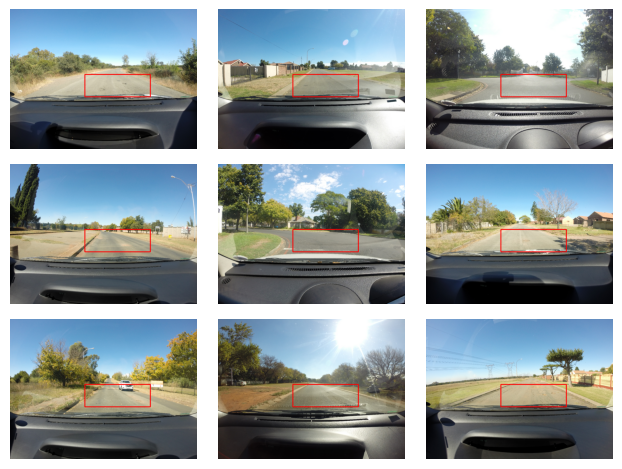

In [271]:
#this function draw a rectangle in the part of the image that we consider the ROI (Region Of Interest)
def draw_rect(image,roi_coords):
    output = cv.resize(image, (1000, 750))
    # Define the angles of the rectangle 
    # (x1, y1) -> top left corner
    # (x2, y2) -> bottom right corner
    start_point = (roi_coords[0], roi_coords[1])
    end_point = (roi_coords[2], roi_coords[3])
    color = (0, 0, 255)
    thickness = 3

    # draw on image
    cv.rectangle(output, start_point, end_point, color, thickness)
    return output

#Define the ROI, excluding lower part comprending the dashboard of the car, the upper part with the sky and the lateral parts
roi_coords = (400, 350, 750, 470) #(x1,y1,x2,y2)
_, axes = plt.subplots(3, 3)
axes[0,0].imshow(cv.cvtColor(draw_rect(cv.imread("test_images/test1.jpg"),roi_coords),cv.COLOR_BGR2RGB))
axes[1,0].imshow(cv.cvtColor(draw_rect(cv.imread("test_images/test2.jpg"),roi_coords),cv.COLOR_BGR2RGB))
axes[2,0].imshow(cv.cvtColor(draw_rect(cv.imread("test_images/test3.jpg"),roi_coords),cv.COLOR_BGR2RGB))
axes[0,1].imshow(cv.cvtColor(draw_rect(cv.imread("test_images/test4.jpg"),roi_coords),cv.COLOR_BGR2RGB))
axes[1,1].imshow(cv.cvtColor(draw_rect(cv.imread("test_images/test5.jpg"),roi_coords),cv.COLOR_BGR2RGB))
axes[2,1].imshow(cv.cvtColor(draw_rect(cv.imread("test_images/test6.jpg"),roi_coords),cv.COLOR_BGR2RGB))
axes[0,2].imshow(cv.cvtColor(draw_rect(cv.imread("test_images/test7.jpg"),roi_coords),cv.COLOR_BGR2RGB))
axes[1,2].imshow(cv.cvtColor(draw_rect(cv.imread("test_images/test8.jpg"),roi_coords),cv.COLOR_BGR2RGB))
axes[2,2].imshow(cv.cvtColor(draw_rect(cv.imread("test_images/test9.jpg"),roi_coords),cv.COLOR_BGR2RGB))

for ax in axes.flat: ax.axis('off')
plt.tight_layout()
plt.show()

Show the ROI in the selected image

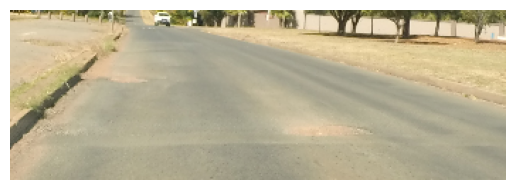

In [272]:
image = cv.imread("test_images/test2.jpg")
image = cv.resize(image, (1000,750))
image = cv.cvtColor(image,cv.COLOR_BGR2RGB)

# y1:y2 ,   x1:x2
roi = image[roi_coords[1]:roi_coords[3], roi_coords[0]:roi_coords[2]]
plt.axis('off')
plt.imshow(roi)

Compute the mean color and the standard deviation in the ROI

In [273]:
mean_color = np.mean(roi, axis=(0, 1))
std_color = np.std(roi, axis=(0, 1))

print(mean_color)
print(std_color)

[182.09857143 172.3242381  142.06054762]
[33.20226969 28.50226746 27.66905312]


Define the range of colors in the ROI that we retain are from the road and show it

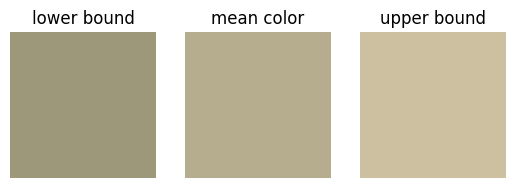

In [274]:
coef = 0.7

lower_bound=np.clip(mean_color - coef * std_color, 0, 255)
lower_bound_image = np.full((100, 100, 3), lower_bound, dtype=np.uint8)

upper_bound=np.clip(mean_color + coef * std_color, 0, 255)
upper_bound_image = np.full((100, 100, 3), upper_bound, dtype=np.uint8)

mean_color_image = np.full((100, 100, 3), mean_color, dtype=np.uint8)
_,axes=plt.subplots(1,3)
axes[0].imshow(lower_bound_image)
axes[0].set_title("lower bound")
axes[1].imshow(mean_color_image)
axes[1].set_title("mean color")
axes[2].imshow(upper_bound_image)
axes[2].set_title("upper bound")

for ax in axes: ax.axis('off')
plt.show()

Create a mask with the colors defined above and extract the road from the image

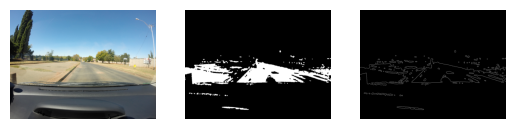

In [275]:
mask = cv.inRange(image, lower_bound, upper_bound)

# Applica operazioni morfologiche per pulire la maschera
kernel = np.ones((4, 4), np.uint8)
mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel)  # Riempie piccoli buchi
mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel)   # Rimuove il rumore

# Applica Canny per rilevare i contorni
edges = cv.Canny(mask, 50, 150)

# Mostra i risultati
_, axes = plt.subplots(1,3)
axes[0].imshow(image)
axes[1].imshow(cv.cvtColor(mask,cv.COLOR_BGR2RGB))
axes[2].imshow(cv.cvtColor(edges,cv.COLOR_BGR2RGB))

for ax in axes: ax.axis('off')
plt.show()

#cv.imshow("image",cv.cvtColor(image,cv.COLOR_BGR2RGB))
#cv.imshow("mask",mask)
cv.waitKey(0)
cv.destroyAllWindows()

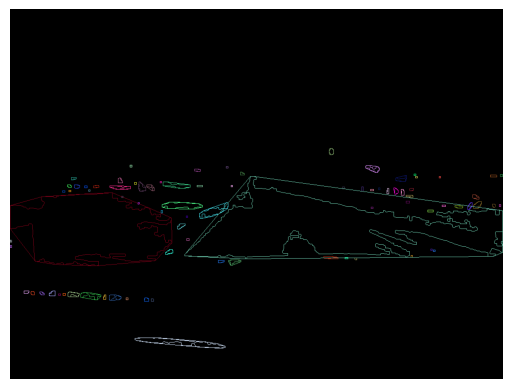

In [276]:
import random as rng
# Find contours
contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
#contours, _ = cv.findContours(edges, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

# Find the convex hull object for each contour
hull_list = []
for i in range(len(contours)):
        hull = cv.convexHull(contours[i])
        hull_list.append(hull)
# Draw contours + hull results
drawing = np.zeros((edges.shape[0], edges.shape[1], 3), dtype=np.uint8)
for i in range(len(contours)):
        color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
        cv.drawContours(drawing, contours, i, color)
        cv.drawContours(drawing, hull_list, i, color)
# Show in a window
plt.axis('off')
plt.imshow(drawing)

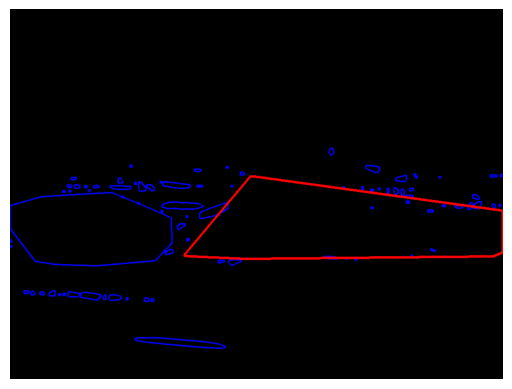

In [277]:
contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Find the convex hull object for each contour
hull_list = [cv.convexHull(cnt) for cnt in contours]
# Draw contours + hull results
largest_hull = max(hull_list, key=cv.contourArea)
#print(largest_hull)
hull_segmentation = np.zeros((edges.shape[0], edges.shape[1], 3), dtype=np.uint8)
for hull in hull_list:
    cv.drawContours(hull_segmentation, [hull], -1, (0, 0, 255), 2)
# Draw the largest hull in green
cv.drawContours(hull_segmentation, [largest_hull], -1, (255, 0, 0), 3)
# Show in a window
plt.axis('off')
plt.imshow(hull_segmentation)

Extract the road segmentation for the next processes

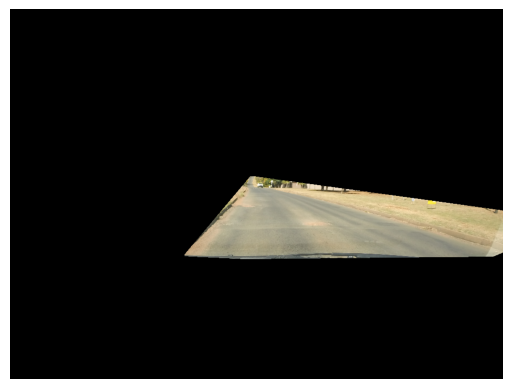

In [278]:
mask = np.zeros_like(cv.cvtColor(image, cv.COLOR_BGR2GRAY))

# Disegna il Convex Hull sulla maschera
cv.fillPoly(mask, [largest_hull], 255)

# Applica la maschera all'immagine originale
road_segmentation = cv.bitwise_and(image, image, mask=mask)
plt.axis('off')
plt.imshow(road_segmentation)

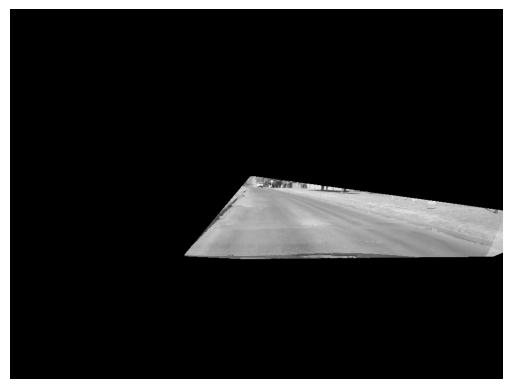

In [279]:
gray_road = cv.cvtColor(road_segmentation,cv.COLOR_RGB2GRAY)
plt.axis('off')
plt.imshow(gray_road,cmap='gray')

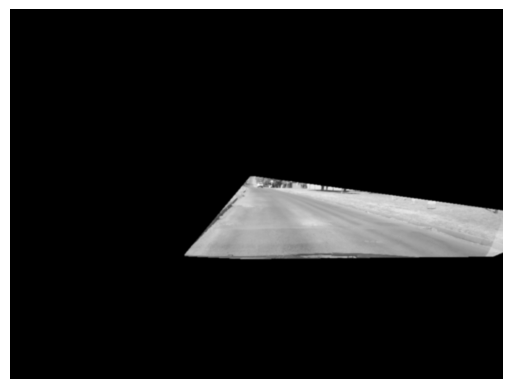

In [280]:
blur = cv.GaussianBlur(gray_road,(5,5),0)
plt.axis('off')
plt.imshow(blur,cmap='gray')

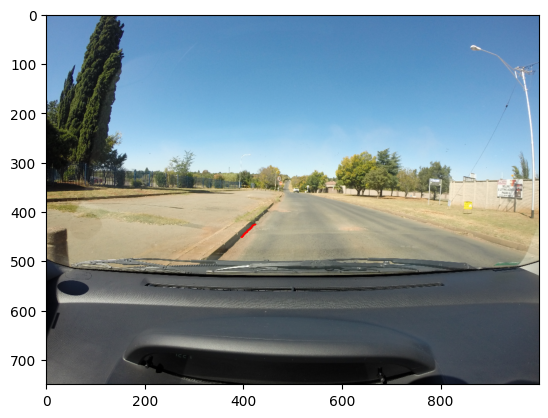

In [281]:
edges = cv.Canny(blur, 50, 150)
kernel = np.ones((5, 5), np.uint8)
dilated = cv.dilate(edges, kernel, iterations=2)
contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
max_size = 30
min_size = 20
potholes = [cnt for cnt in contours if max_size > cv.contourArea(cnt) > min_size]
output = image.copy()
cv.drawContours(output, potholes, -1, (255, 0, 0), 2)
output_resized = cv.resize(output, (1000, 750))
plt.imshow(output_resized)